In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sasviya.ml.tree import ForestClassifier
from sklearn.preprocessing import LabelEncoder
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Read Data

In [2]:
df_data = pd.read_csv('../data/diabetes_prediction_dataset.csv')
print('Number of Observations:', df_data.shape[0])
print('Number of Features Available:', df_data.shape[1]-1)
df_data.head()

Number of Observations: 768
Number of Features Available: 8


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### Data Dictionary:
* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Binary target variale, 1=individual has diabetes, 0=individual does NOT have diabetes

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Let's bin the age variable
bins = [18, 24, 34, 44, 54, df_data['Age'].max()]
names = ['18-24', '25-34', '35-44', '45-54', '55+']

df_data['Age'] = pd.cut(df_data['Age'], bins, labels=names)

### Visualize it

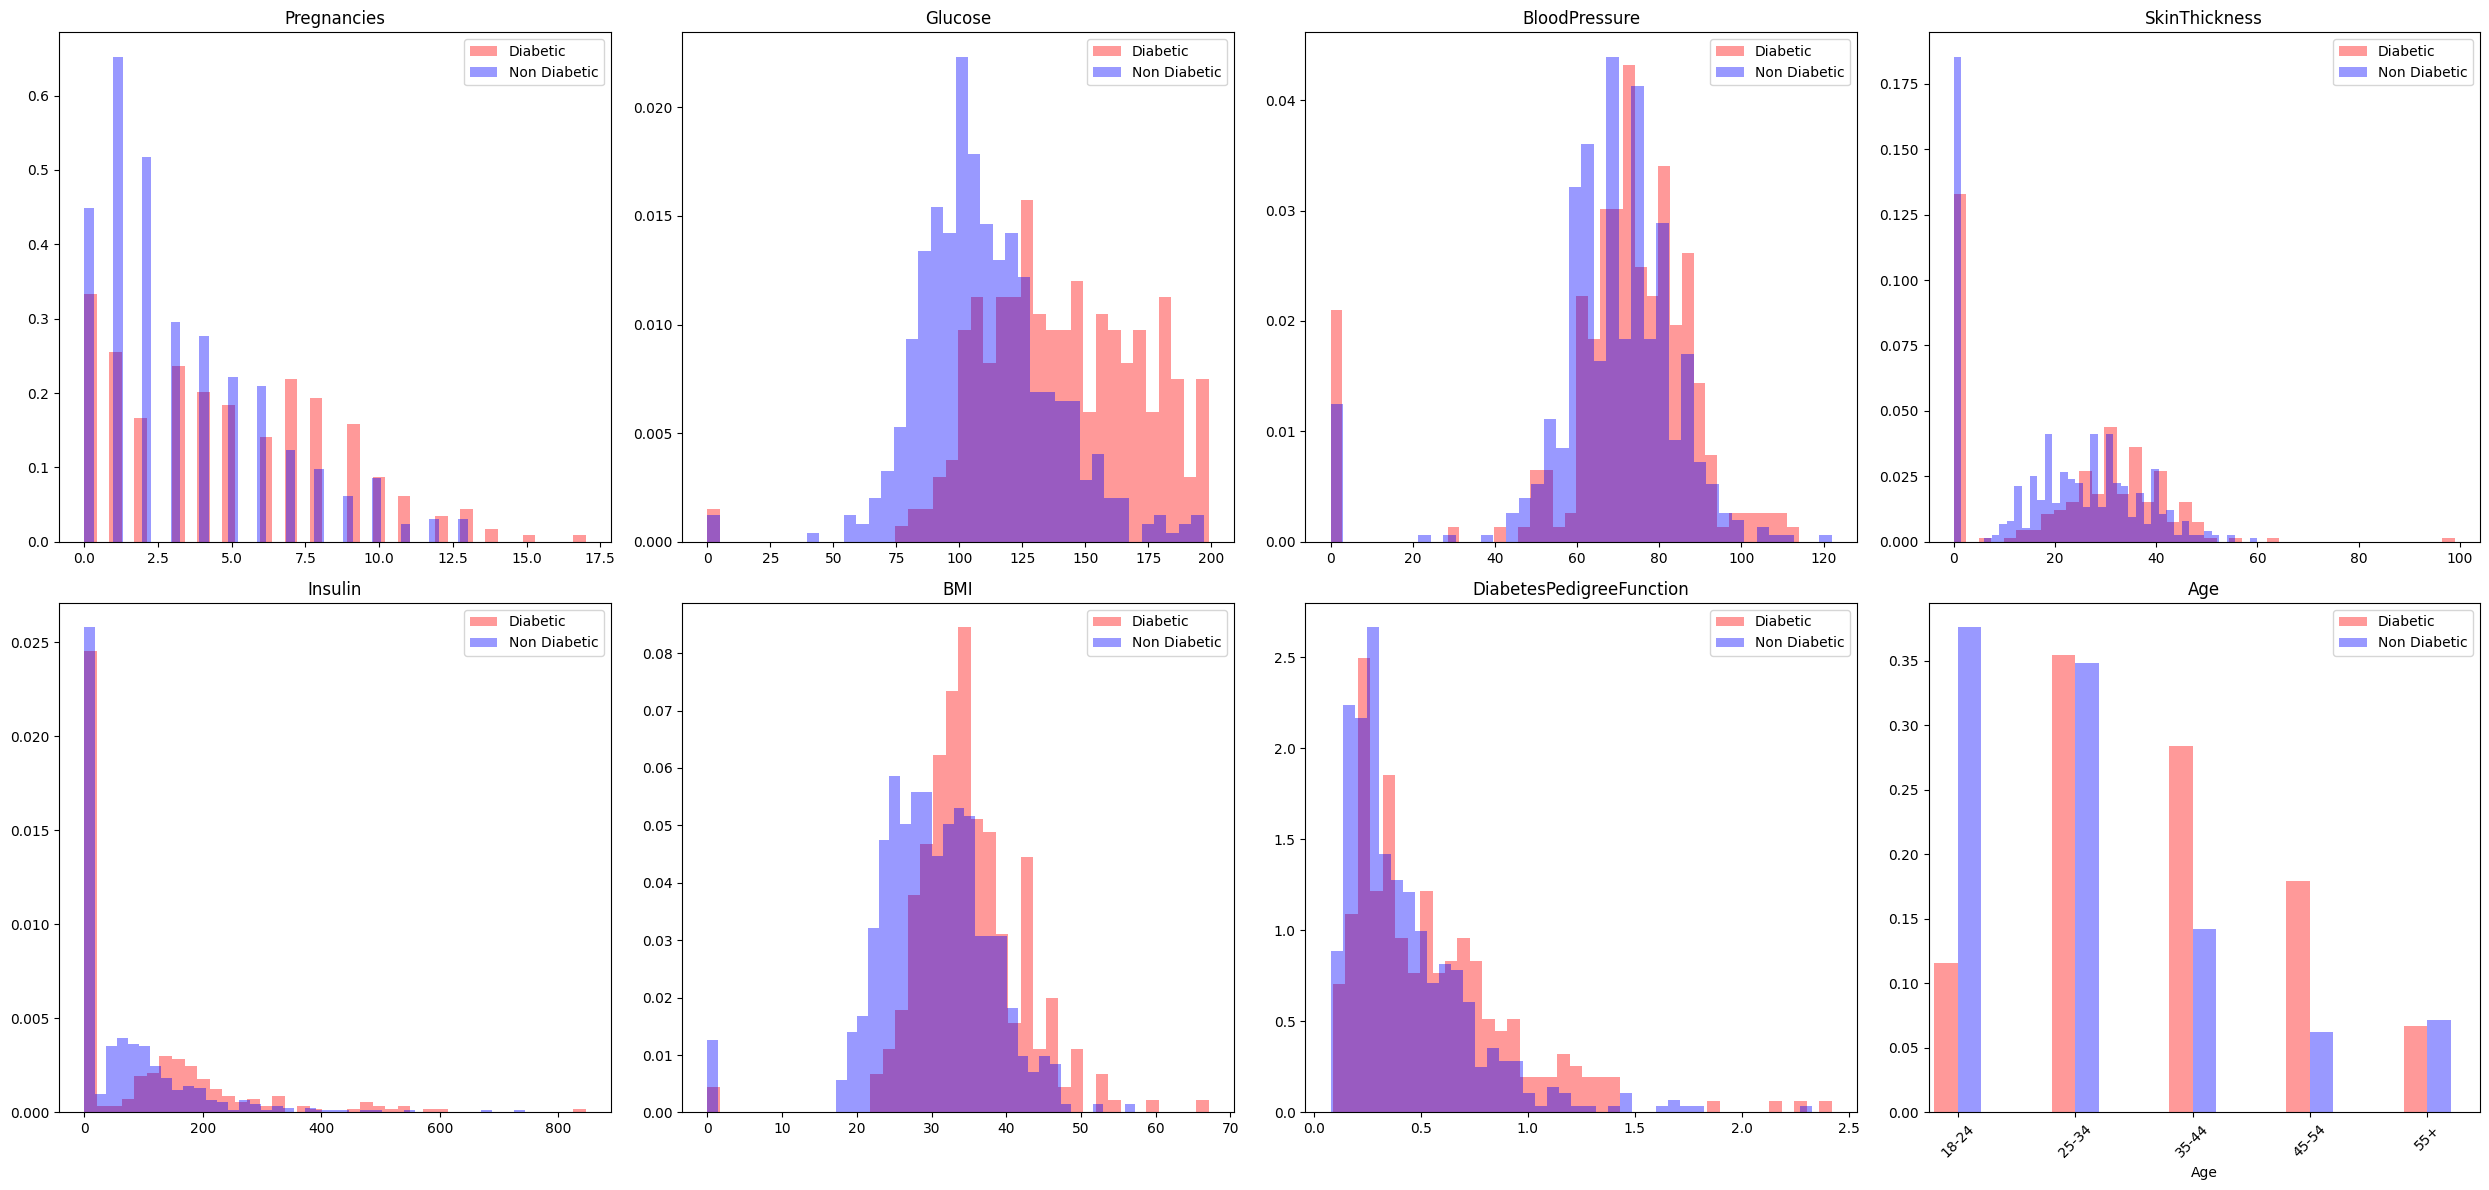

In [5]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(25, 12))
axs = axs.ravel()
columns = list(df_data.columns)
for i in range(len(axs)):
    ax=axs[i]
    if df_data[columns[i]].dtype in ['float64', 'int64']:
        ax.hist(df_data[df_data['Outcome']==1][columns[i]], bins=40, color='red', alpha=0.4, density=True, label='Diabetic')
        ax.hist(df_data[df_data['Outcome']==0][columns[i]], bins=40, color='blue', alpha=0.4, density=True, label='Non Diabetic')
    else:
        df_data[df_data['Outcome']==1][columns[i]].value_counts(normalize=True).to_frame().\
            sort_values(by=columns[i]).plot(y='proportion',kind='bar', ax=ax, color='red', rot=45, label='Diabetic', alpha=0.4, position=1, width=0.2)
        df_data[df_data['Outcome']==0][columns[i]].value_counts(normalize=True).to_frame().\
            sort_values(by=columns[i]).plot(y='proportion',kind='bar', ax=ax, color='blue', rot=45, label='Non Diabetic', alpha=0.4, position=0, width=0.2)
    ax.legend()
    ax.set_title(columns[i])
plt.tight_layout()
plt.show()

In [6]:
correlation_cols = [i for i in df_data.columns if i!='Age']
df_data[correlation_cols].corr().style.background_gradient(cmap=plt.cm.Blues).format(precision=2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.17
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,1.00


In [7]:
target = 'Outcome'
pd.concat([df_data[target].value_counts().to_frame(), df_data[target].value_counts(normalize=True).to_frame()], axis=1)

,count,proportion
Outcome,,
0,500,0.651042
1,268,0.348958


### Machine Learning Modelling

In [8]:
df_data['stratification_key']= df_data['Age'].astype(str)+'-'+df_data[target].astype(str)
train, test = train_test_split(df_data, train_size=0.7, stratify=df_data['stratification_key'])
valid, test =train_test_split(test, train_size=0.667, stratify=test['stratification_key'])
print('Train Size:', train.shape[0], '--- Diabetes Frequency:', f'{round(100*train.Outcome.sum()/train.shape[0],2)}%')
print('Valid Size:', valid.shape[0], '--- Diabetes Frequency:', f'{round(100*valid.Outcome.sum()/valid.shape[0],2)}%')
print('Test Size:', test.shape[0], '--- Diabetes Frequency:', f'{round(100*test.Outcome.sum()/test.shape[0],2)}%')

Train Size: 537 --- Diabetes Frequency: 34.82%
Valid Size: 154 --- Diabetes Frequency: 35.06%
Test Size: 77 --- Diabetes Frequency: 35.06%


In [9]:
Age_encoder = LabelEncoder()
train['Age']=Age_encoder.fit_transform(train['Age'])
valid['Age']=Age_encoder.transform(valid['Age'])
test['Age']=Age_encoder.transform(test['Age'])

In [10]:
train_valid = pd.concat([train, valid])
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']

partial_viya = ForestClassifier(random_state=SEED)
partial_viya.fit(train[features], train[target].to_numpy().astype(int))
print('Valid F1 Score:', round(100*f1_score(valid[target], partial_viya.predict(valid[features])),2))

final_viya = ForestClassifier(random_state=SEED)
final_viya.fit(train_valid[features], train_valid[target].to_numpy().astype(int))
print('Test F1 Score:', round(100*f1_score(test[target], final_viya.predict(test[features])),2))

Valid F1 Score: 65.31
Test F1 Score: 68.0


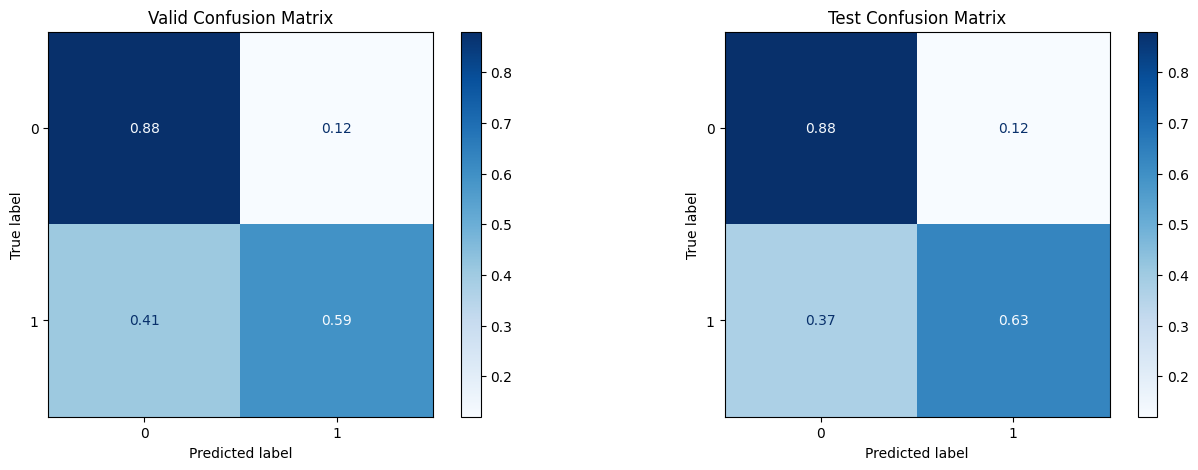

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
disp = ConfusionMatrixDisplay(confusion_matrix(valid[target], partial_viya.predict(valid[features]), normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Valid Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test[target], final_viya.predict(test[features]), normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title('Test Confusion Matrix')
plt.show()

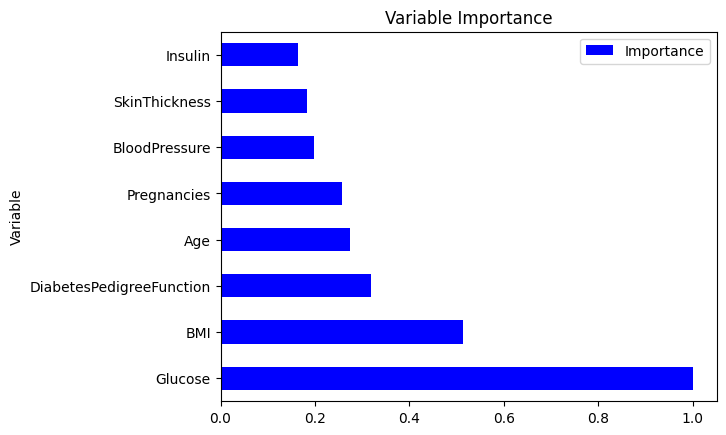

In [12]:
imps_viya = final_viya.feature_importances_
imps_viya['Importance']/=max(imps_viya['Importance'])

imps_viya.plot.barh(x='Variable', y='Importance', color='blue')
plt.title('Variable Importance')
plt.show()

In [13]:
test['Viya_Pred']=final_viya.predict(test[features])
test['P_diabetes1_Viya']=final_viya.predict_proba(test[features]).iloc[:,1]
test['P_diabetes0_Viya']=final_viya.predict_proba(test[features]).iloc[:,0]

train_valid['Age']=Age_encoder.inverse_transform(train_valid['Age'])
test['Age']=Age_encoder.inverse_transform(test['Age'])

newpath = '../output' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

test.to_csv(f'{newpath}/test_predictions.csv', index=False)
train_valid.to_csv(f'{newpath}/train_valid.csv', index=False)